## Les imports 

In [134]:
import numpy as np

from MacsumAggregationLearning import *
from typing import Tuple

import csv
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Géneration des données

In [108]:

N = 2
# C'est le vrai noyau que l'on va essayer de retrouver
phi_true = np.random.uniform(low=-1.0, high=1.0, size=N) 
macsum_true = Macsum(N,phi_true)
print(f"True Kernel : {phi_true}")

True Kernel : [-0.81251159 -0.86656395]


In [109]:
def generate_data_for_macsum(
    macsum, 
    phi_true,
    n_samples: int, 
    noise_level: float = 0.01,
    borne: int = 50.0
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Génère un jeu de données (X, Y) qui suit la logique du modèle Macsum.
    CORRIGÉE : y_inside est maintenant bien généré à l'intérieur de l'intervalle.
    """
    n = len(phi_true)
    n_samples= int(n_samples * 1.1)
    
    X  = np.random.uniform(low=-borne, high=borne, size=(n_samples,n))
    Y = np.zeros(n_samples)

    for i in range(n_samples):
        x = X[i]

        y_lower_true, y_upper_true = macsum.prediction(x)
        
        
        y_inside = (y_upper_true + y_lower_true)/2
        
        # 3. Ajouter un peu de bruit de mesure (gaussien) pour plus de réalisme.
        interval_spread = y_upper_true - y_lower_true
        if interval_spread < 1e-6:
             interval_spread = 1.0 # Éviter la division par zéro
             
        noise = np.random.randn() * noise_level * interval_spread
        
        Y[i] = y_inside + noise

    eval_index = int(n_samples*0.1)
    return X[eval_index:], Y[eval_index:], X[:eval_index], Y[:eval_index]

In [110]:
def save_data(X,Y,name="data"):

    # Convertir la matrice numpy en DataFrame
    label = [ f"x{i}"for i in range( X.shape[1])]
    label.insert(-1,"target")
    df = pd.DataFrame(np.column_stack((X, Y)), columns=label)

    # Sauvegarder dans CSV
    df.to_csv(name+'.csv', index=False)

In [111]:
X,Y,X_eval,Y_eval = generate_data_for_macsum( macsum_true,phi_true,1000,borne=50)
print(X_eval,Y_eval)

[[-21.81605084 -47.27390615]
 [  8.96327028  -5.03620681]
 [ -3.33577351  25.08667154]
 [ 22.48293811  37.5189526 ]
 [ 43.79390741  49.46915267]
 [-29.99635165 -46.6797233 ]
 [ 23.68550501  30.3953187 ]
 [  9.21567686   6.6315601 ]
 [ 19.65091009 -46.28772348]
 [ 22.74815694 -33.88296375]
 [ 36.49116747  30.84985424]
 [-35.08778802   3.03432842]
 [-36.3379773   41.19849365]
 [  9.08558609  36.99411573]
 [ 37.2715996   15.41371011]
 [ -8.13074636  43.28122355]
 [ -7.86817363 -10.30600743]
 [  8.11576072 -21.68926188]
 [  9.68958098 -19.62029801]
 [ 11.69526049  18.63654317]
 [-21.18023966  -0.64736968]
 [ -6.18122078 -38.28280817]
 [-18.86028147 -39.48604695]
 [-34.6702214   14.65426839]
 [  3.41229781  23.00449307]
 [ 20.19918843  28.34302429]
 [-32.22422046  46.91388808]
 [  0.88921058 -44.38611674]
 [ 36.78633369 -13.21511189]
 [-28.35290693  20.08719971]
 [ 27.77819974 -15.83123411]
 [-44.31212156  35.95791704]
 [ 31.79439931 -40.78228332]
 [-26.59181472   9.20882837]
 [ 41.34462995

## Entrainement

### Moindres carrés pour un noyau initial

In [112]:
initial_phi, _, _, _ = np.linalg.lstsq(X, Y, rcond=None)
print(initial_phi)

[-0.37962828 -0.43286018]


In [113]:
macsum = Macsum(N,initial_phi)
evaluate_model(X,Y,macsum)

{'containment_rate': 0.49797979797979797,
 'avg_distance_to_interval': 7.269112903676498,
 'avg_loss': 308.48676887213395,
 'avg_interval_spread': 14.318582920137446}

In [115]:
macsum = Macsum(N)
macsum.fit(X,Y,X_eval,Y_eval,n_iteration=1000,alpha=1e-2,epsilon=1e-4)

Entraînement ::   0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'Macsum' object has no attribute '_gradient_function'

In [ ]:
plot_metrics(macsum.history)
evaluate_model(X,Y,macsum)

In [116]:
macsum =  Macsum(N)
macsum.fit_adam(X,Y,X_eval,Y_eval,n_epochs=2000,learning_rate=1e-4,epsilon_conv=1e-5,batch_size=64)

Début de l'entraînement avec l'optimiseur Adam...


Entraînement Adam: 100%|██████████| 2000/2000 [01:22<00:00, 24.17it/s]

Entraînement terminé (nombre maximum d'époques atteint).


array([-0.68437563, -0.68435668])

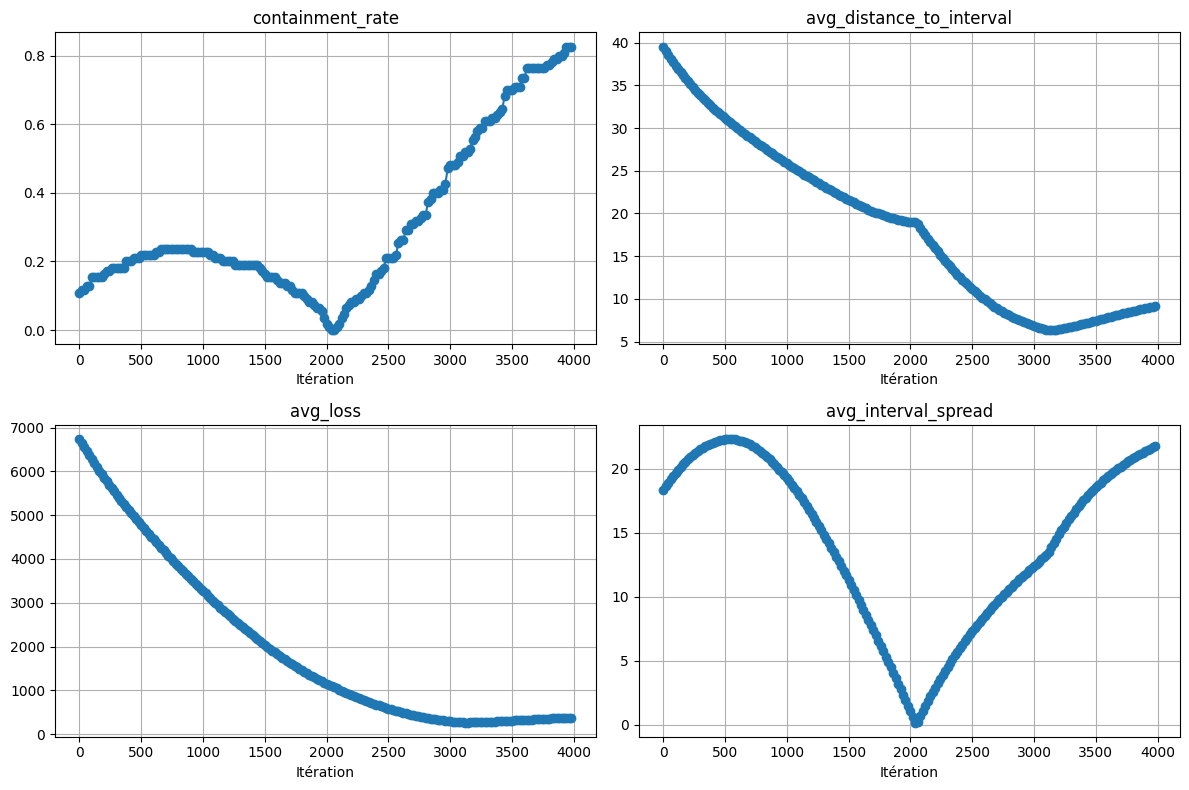

{'containment_rate': 0.8292929292929293,
 'avg_distance_to_interval': 9.686343830602189,
 'avg_loss': 404.6212419066833,
 'avg_interval_spread': 22.63846305665556}

In [117]:
plot_metrics(macsum.history)
evaluate_model(X,Y,macsum)

In [131]:
macsum_sigmoide =  Macsum_sigmoide(N,alpha=0.1,gamma=0.6,k_sigmoid=0.01)
macsum_sigmoide.fit_adam(X,Y,X_eval,Y_eval,n_epochs=5000,learning_rate=1e-4,epsilon_conv=1e-6,batch_size=128,beta1=0.7,beta2=0.99)

Début de l'entraînement avec l'optimiseur Adam...


Entraînement Adam: 100%|██████████| 5000/5000 [03:42<00:00, 22.47it/s]

Entraînement terminé (nombre maximum d'époques atteint).


array([-0.80409871, -0.80412008])

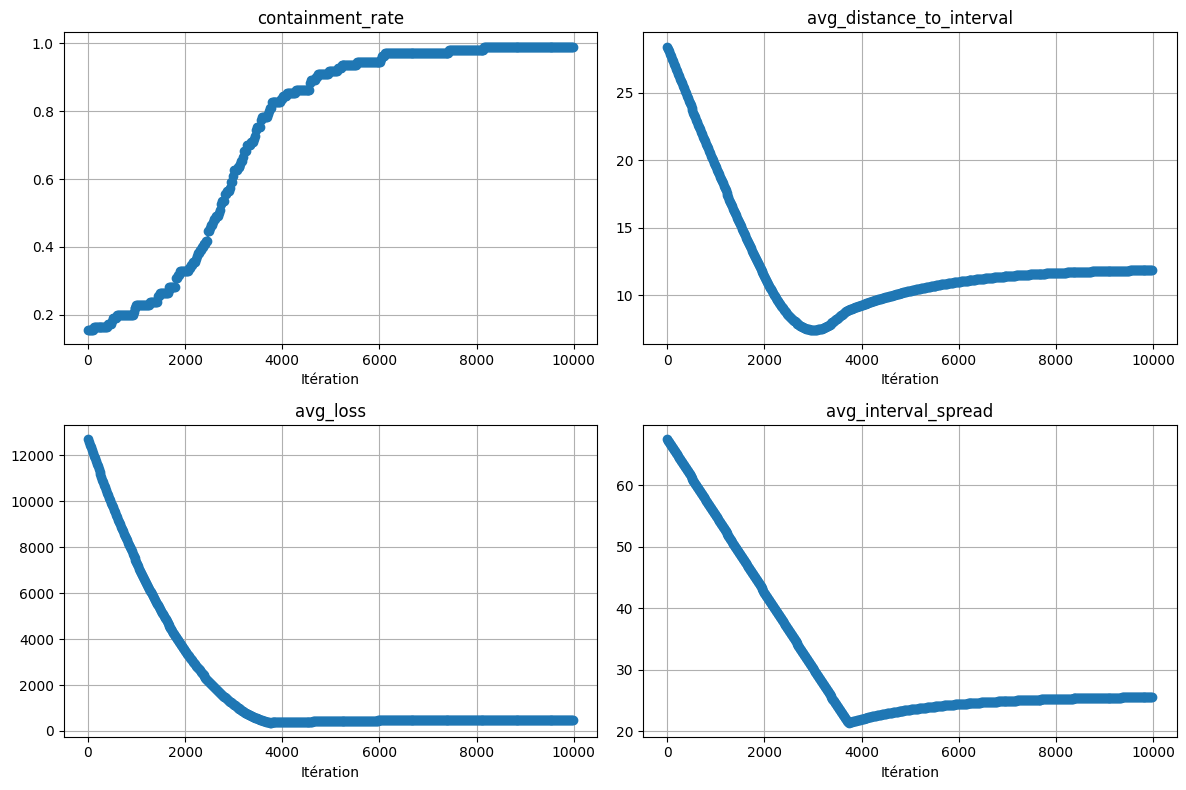

{'containment_rate': 0.9888888888888889,
 'avg_distance_to_interval': 12.403300681674478,
 'avg_loss': 539.6647035304762,
 'avg_interval_spread': 26.59948985082443}

In [132]:
plot_metrics(macsum_sigmoide.history)
evaluate_model(X,Y,macsum_sigmoide)

In [106]:
print(np.linalg.norm(macsum.phi-phi_true))
print(np.linalg.norm(macsum_sigmoide.phi-phi_true))

0.2647195251691647
0.261740254766316


In [107]:
save_data(X,Y,"train_simoide_classique")
save_data(X_eval,Y_eval,"test_simoide_classique")